In [1]:
from difference_models import BinaryDifferenceClassifier, MulticlassDifferenceClassifier
import util
from shap.maskers import Independent
from sklearn.utils import resample, shuffle
from sklearn.decomposition import PCA
from shap.plots import colors
import shap
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
%matplotlib inline
shap.initjs()

In [2]:
with open('dataset.pickle', 'rb') as f:
    X, y, feature_names, n_features, n_samples = pickle.load(f)
with open('classifiers.pickle', 'rb') as f:
    clf_a, clf_b = pickle.load(f)


In [3]:
try:
    with open(f'shapvalues.soa.pred.pickle', 'rb') as f:
        shap_values_a, shap_values_b = pickle.load(f)
        print('Loaded cached shap values')
except FileNotFoundError:
    print('No cached shap values found')

No cached shap values found


## Generate Explanations

And now we calculate SHAP values for each function:

In [5]:
%%time

background_data = X
def explain(predict):
    masker = Independent(data=background_data, max_samples=100)
    explainer = shap.Explainer(predict, masker, feature_names=feature_names)
    shap_values = explainer(X)
    return shap_values

shap_values_a = explain(lambda X: util.encode_one_hot(clf_a.predict(X), len(clf_a.classes_)))
shap_values_b = explain(lambda X: util.encode_one_hot(clf_b.predict(X), len(clf_b.classes_)))

with open(f'shapvalues.soa.pred.pickle', 'wb') as f:
    pickle.dump((shap_values_a, shap_values_b), f, pickle.HIGHEST_PROTOCOL)

CPU times: user 2 s, sys: 25.5 ms, total: 2.03 s
Wall time: 2.08 s


## Analyze

Preparations:

In [45]:
shap_values_a_vs_b = shap_values_b - shap_values_a
shap_values_a_vs_b.data = shap_values_a.data
shap_values_a_vs_b.display_data = shap_values_a.display_data
feature_order = np.flip(shap_values_a_vs_b.abs.mean(axis=2).mean(axis=0).values.argsort())

In [46]:
indices = np.indices(y.shape).ravel()
diff_clf = MulticlassDifferenceClassifier(clf_a, clf_b)
diff_clf.fit(X, y)
binary_diff_clf = BinaryDifferenceClassifier(clf_a, clf_b)
binary_diff_clf.fit(X, y)
is_pred_equal = binary_diff_clf.predict(X)
is_pred_diff = ~is_pred_equal
pred = diff_clf.predict(X)
indices_pred_equal = np.argwhere(is_pred_equal).ravel()
if indices_pred_equal.shape[0] > 250:
    indices_pred_equal = resample(indices_pred_equal, replace=False, random_state=42, n_samples=250, stratify=pred[indices_pred_equal])
indices_pred_diff = np.argwhere(is_pred_diff).ravel()
if indices_pred_diff.shape[0] > 250:
    indices_pred_diff = resample(indices_pred_diff, replace=False, random_state=42, n_samples=250, stratify=pred[indices_pred_diff])
indices_sample = np.concatenate((indices_pred_equal, indices_pred_diff))

### Feature Importance

#### Bar Plots

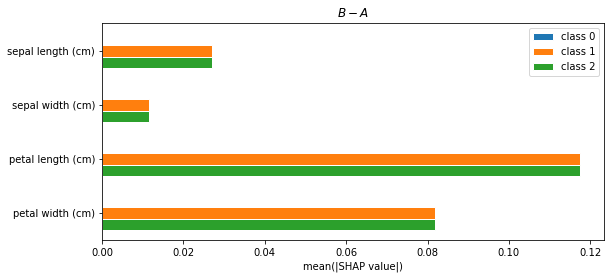

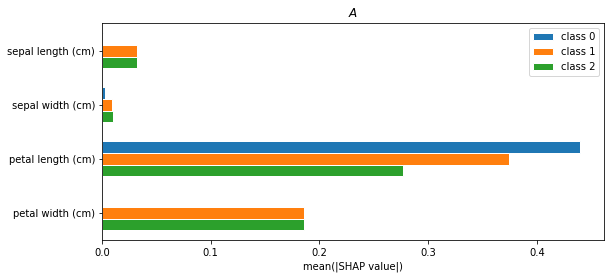

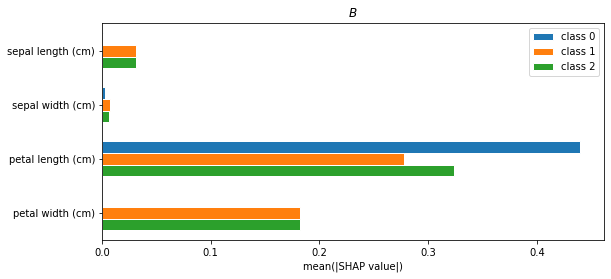

In [47]:
bar_width = 0.22

for name, shap_values in [('B-A', shap_values_a_vs_b), ('A', shap_values_a), ('B', shap_values_b)]:
    importances = shap_values.abs.mean(0).values.T
    rects = [i * bar_width + np.arange(importances.shape[1]) for i in range(importances.shape[0])]
    fig, ax = plt.subplots(figsize=(9, n_features))
    for class_idx, rect, importance in zip(diff_clf.classes_, rects, importances):
        ax.barh(rect, importance, height=bar_width, edgecolor='white', label=f'class {class_idx}')
    ax.set_xlabel('mean(|SHAP value|)')
    ax.set_yticks([r + bar_width * (importances.shape[0] - 1)/2 for r in range(importances.shape[1])])
    ax.set_yticklabels(feature_names)
    ax.invert_yaxis()
    ax.legend()
    ax.set_title(f'${name}$')
    plt.show()

#### SHAP Value Distribution

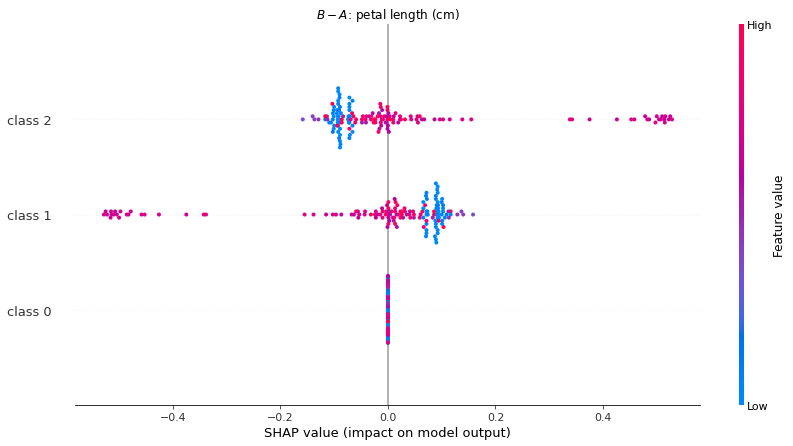

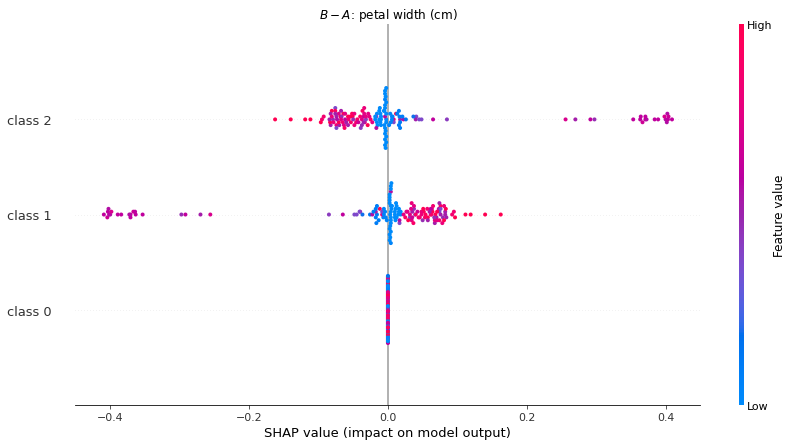

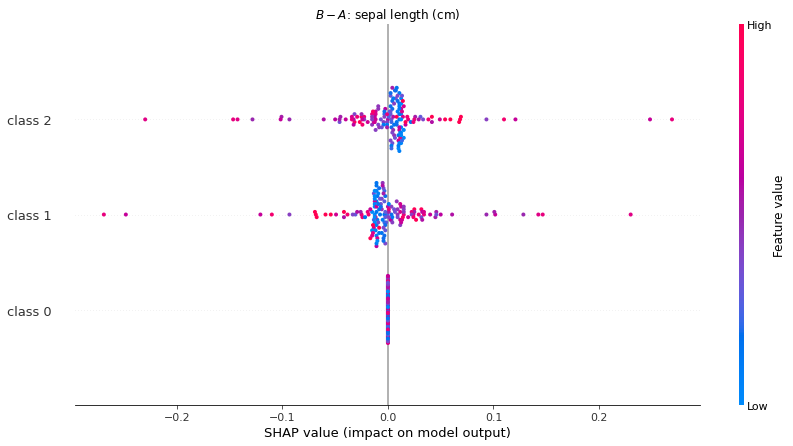

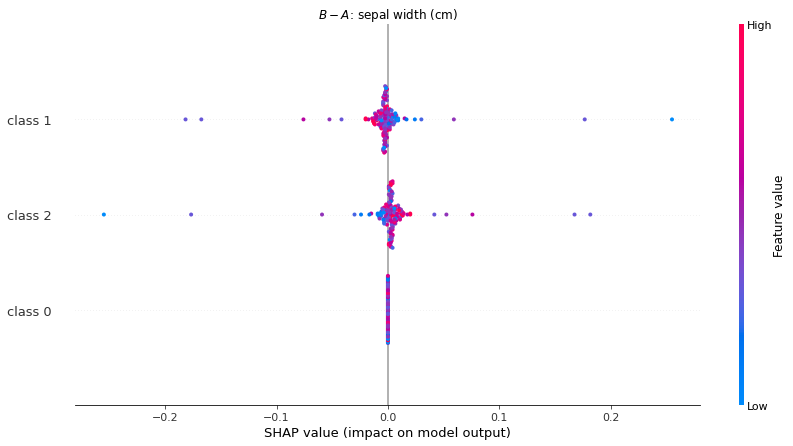

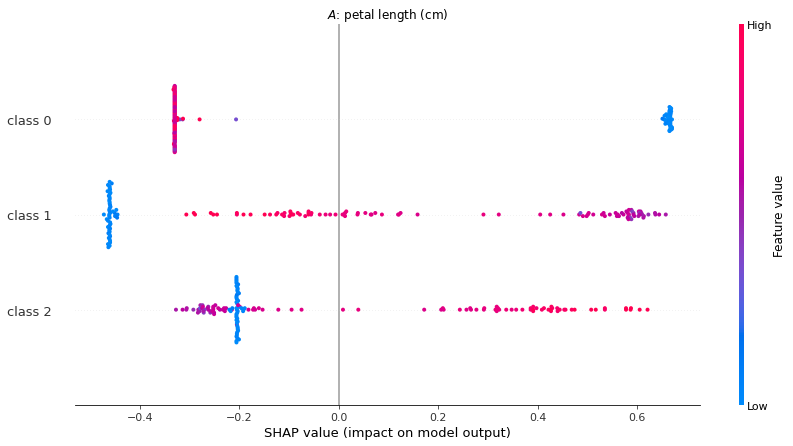

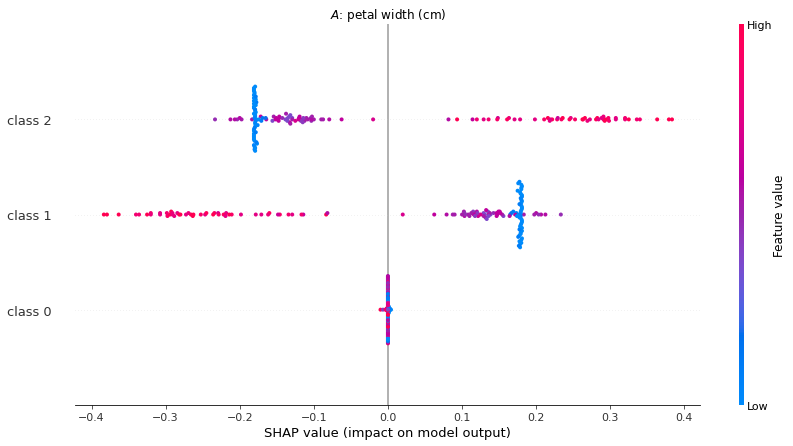

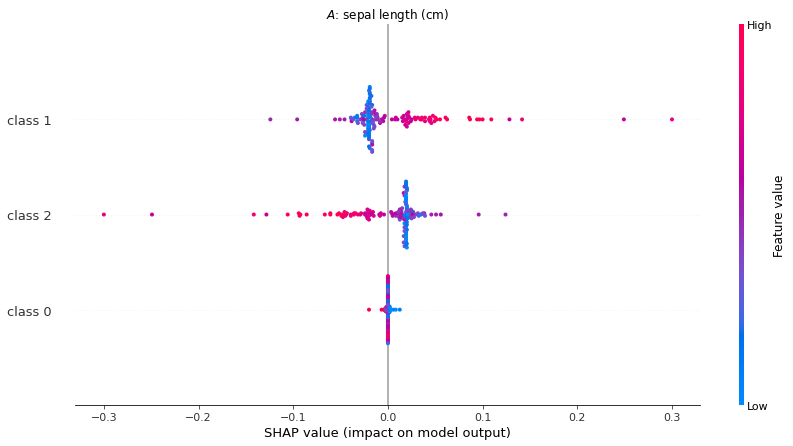

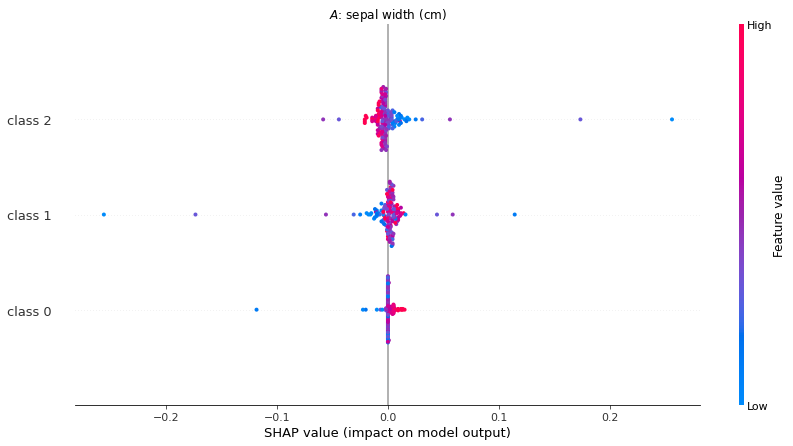

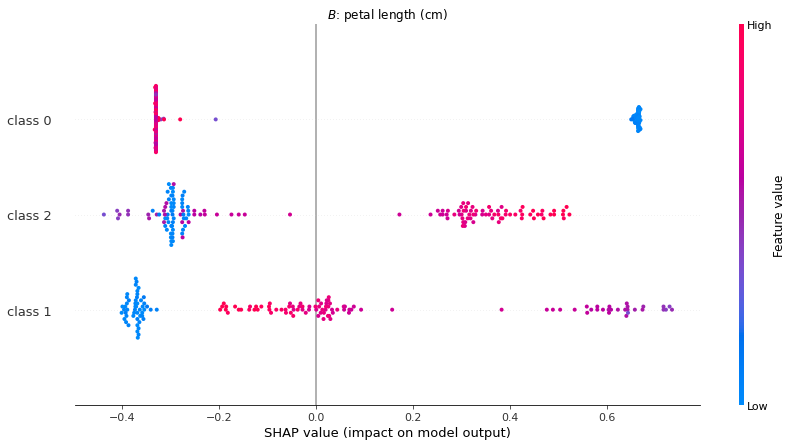

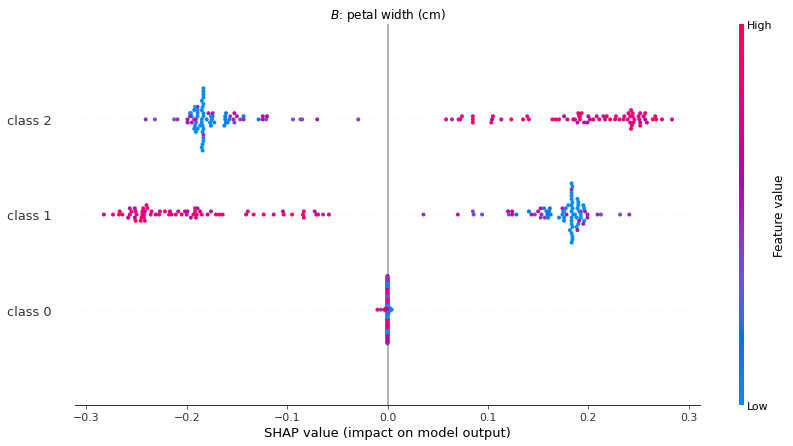

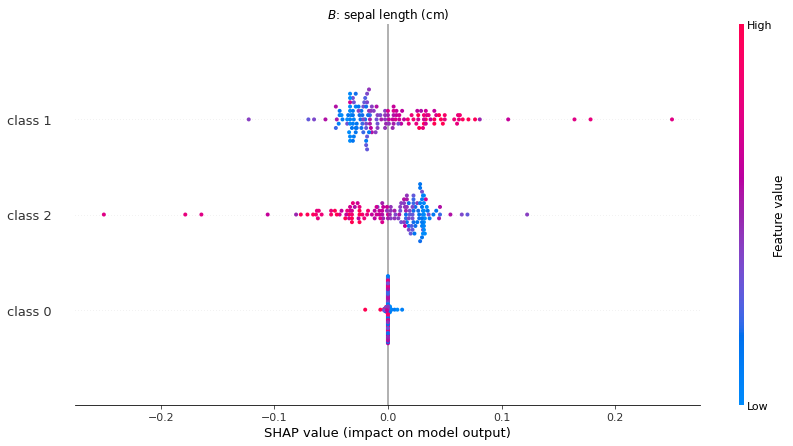

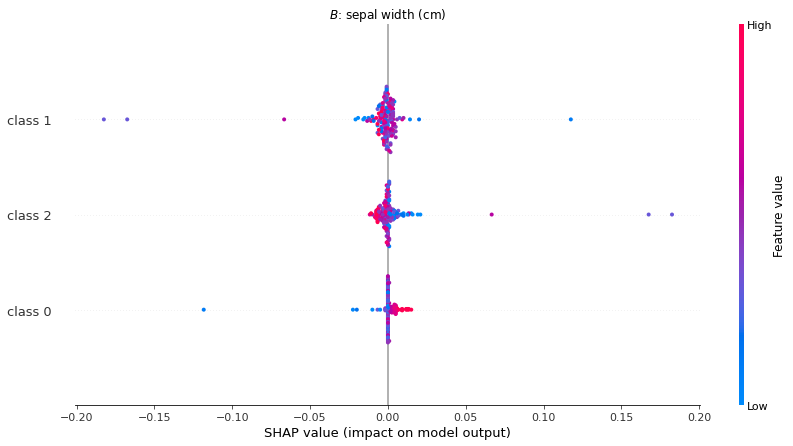

In [55]:
for name, shap_values in [('B-A', shap_values_a_vs_b), ('A', shap_values_a), ('B', shap_values_b)]:
    for feature_idx in feature_order:
        new_values = shap_values.values[:, feature_idx, :]
        new_data = np.reshape(np.repeat(shap_values.data[:, feature_idx], shap_values.values.shape[2]),
                              (X.shape[0], shap_values.values.shape[2]))
        if shap_values.display_data is not None:
            new_display_data = np.reshape(np.repeat(shap_values.display_data[:, feature_idx], shap_values.values.shape[2]),
                                          (X.shape[0], shap_values.values.shape[2]))
        else:
            new_display_data = None
        new_base_values = shap_values.base_values
        class_names = [f'class {class_}' for class_ in clf_a.classes_]
        shap_values_ = shap.Explanation(new_values, new_base_values, new_data, new_display_data, feature_names=class_names)
        shap.plots.beeswarm(shap_values_, plot_size=(14, 7), show=False)
        plt.title(f'${name}$: {feature_names[feature_idx]}')
        plt.show()

### Feature Effects

#### Partial Dependence Plots

Here we investigate the effect a feature has no the model output. Plot in blue are the instances where A and B predict the same label, plot over in red are instances where they differ. The last column shows the difference between the two classifiers' SHAP values.

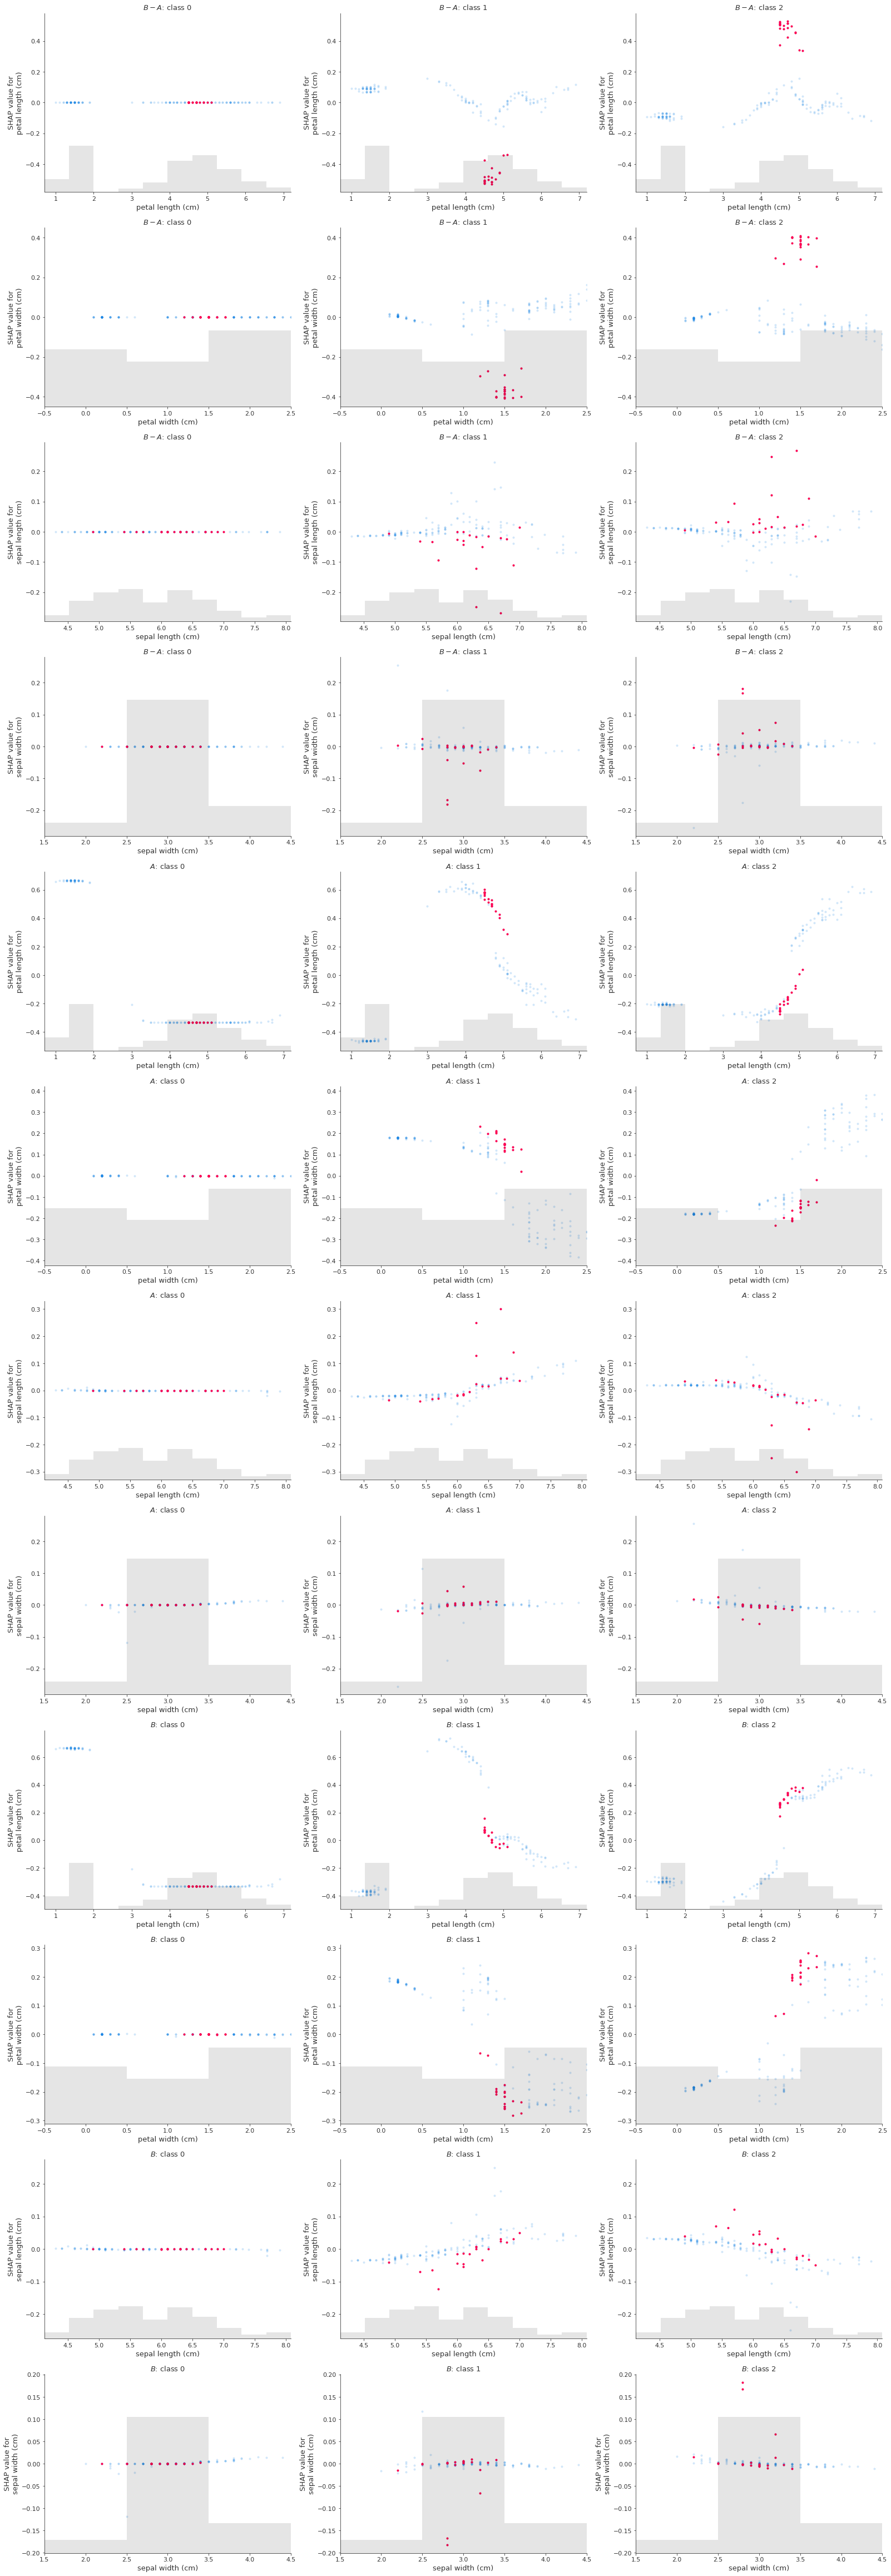

In [52]:
n_columns = len(clf_a.classes_)
n_rows = n_features * 3
fig = plt.figure(figsize=(9 * n_columns, 7 * n_rows))
plot_idx = 1
for name, shap_values in [('B-A', shap_values_a_vs_b), ('A', shap_values_a), ('B', shap_values_b)]:
    for feature in feature_names[feature_order]:
        ax_ref = None
        for class_idx, class_ in enumerate(clf_a.classes_):
            ax = fig.add_subplot(n_rows, n_columns, plot_idx, sharey=ax_ref)
            if not ax_ref:
                ax_ref = ax
            shap.plots.scatter(shap_values[:, feature, class_idx],
                               ax=ax, alpha=0.2, show=False)
            shap.plots.scatter(shap_values[is_pred_diff, feature, class_idx],
                               ax=ax, title=f'${name}$: class {class_}', 
                               color=tuple(colors.red_rgb),
                               hist=False, show=False)
            plot_idx += 1
plt.show()

### Cluster

#### Principal components
Visualize the first two principal components of the SHAP-values

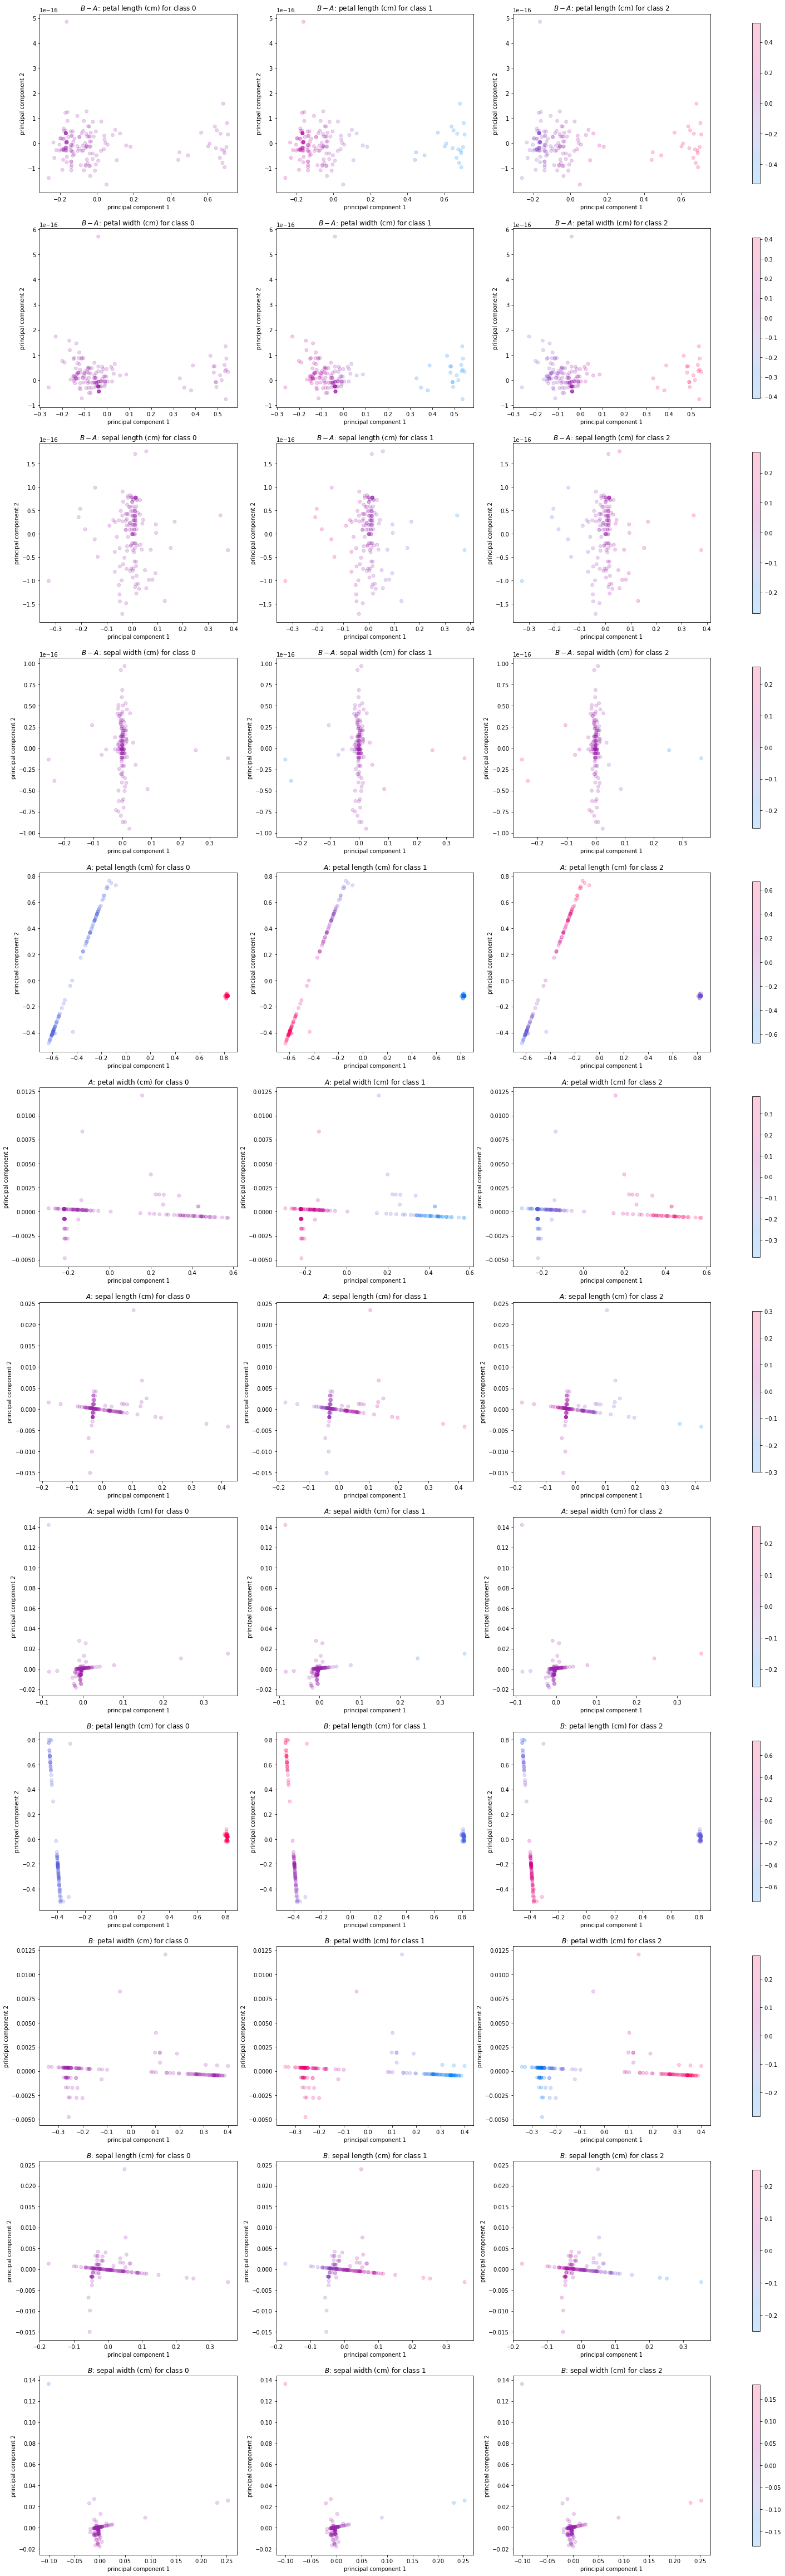

In [69]:
n_columns = len(clf_a.classes_)
n_rows = n_features * 3
fig, axs = plt.subplots(n_rows, n_columns, figsize=(9*n_columns, 7*n_rows))
plot_idx = 0
for name, shap_values in [('B-A', shap_values_a_vs_b), ('A', shap_values_a), ('B', shap_values_b)]:
    for feature_idx in feature_order:
        shap_values_ = shap_values[:, feature_idx, :]
        pca = PCA(2)
        embedding_values = pca.fit_transform(shap_values_.values)
        vmax = np.max(np.abs(shap_values_.values))
        for class_idx, class_ in enumerate(clf_a.classes_):
            ax = axs.flat[plot_idx]
            cs = ax.scatter(embedding_values[:, 0],
                            embedding_values[:, 1],
                            c=shap_values_.values[:, class_idx],
                            vmin=-vmax, vmax=vmax,
                            cmap=colors.red_blue,
                            alpha=0.2)
            ax.set_title(f'${name}$: {feature_names[feature_idx]} for class ${class_}$')
            ax.set_xlabel('principal component 1')
            ax.set_ylabel('principal component 2')
            plot_idx += 1
        fig.colorbar(cs, ax=axs[int((plot_idx-1)/3)].tolist(), shrink=0.9)
plt.show()

#### Force plots

In [82]:
for name, shap_values in [('B-A', shap_values_a_vs_b), ('A', shap_values_a), ('B', shap_values_b)]:
    instance_order = None
    for class_idx, class_ in enumerate(clf_a.classes_):
        shap_values_ = shap_values[indices_sample, :, class_idx]
        data = shap_values_.display_data if shap_values_.display_data is not None else shap_values_.data
        plot = shap.plots.force(
            base_value=shap_values_.base_values[0],
            shap_values=shap_values_.values,
            features=data,
            feature_names=feature_names,
            ordering_keys=instance_order,
            out_names=f'{name}: class {class_}')
        instance_order = util.get_force_plot_ordering(plot)
        display(plot)

#### Heatmaps

SHAP heatmaps provide a way to cluster instances, using the hclust algorithm.

invalid value encountered in true_divide
invalid value encountered in true_divide


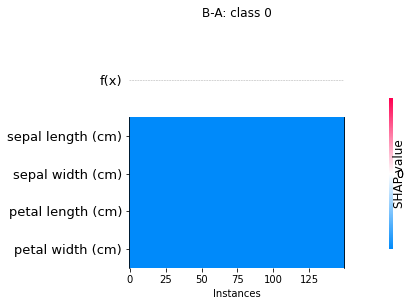

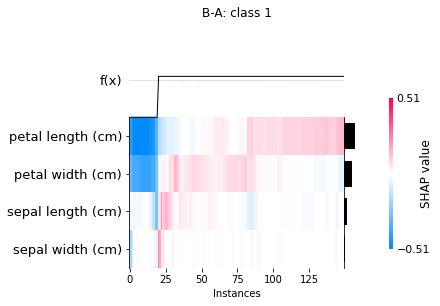

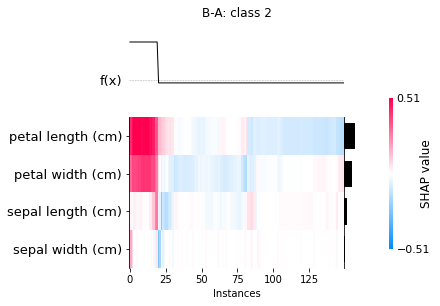

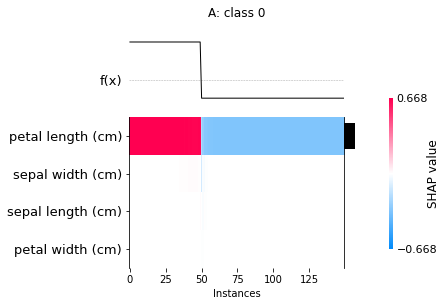

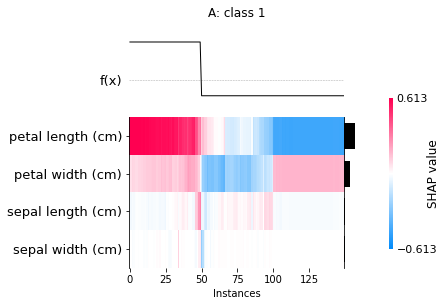

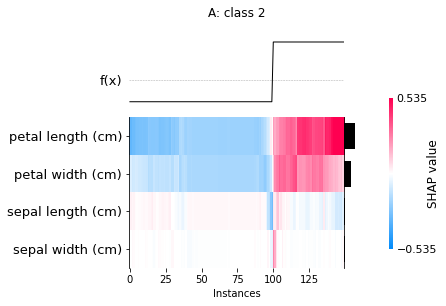

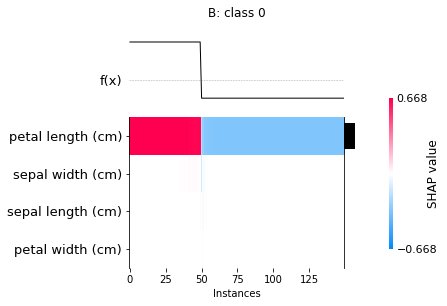

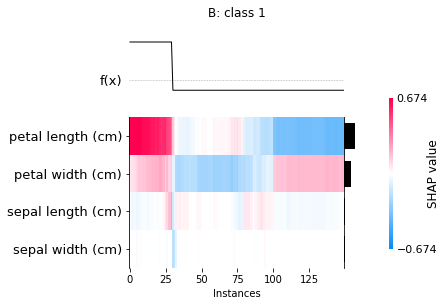

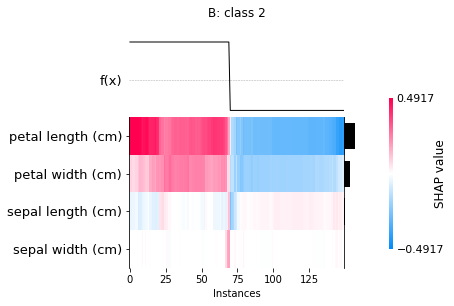

In [83]:
for name, shap_values in [('B-A', shap_values_a_vs_b), ('A', shap_values_a), ('B', shap_values_b)]:
    for class_idx, class_ in enumerate(clf_a.classes_):
        shap_values_ = shap_values[indices_sample, :, class_idx]
        shap.plots.heatmap(shap_values_, max_display=n_features, show=False)
        plt.title(f'{name}: class {class_}')
        plt.show()

#### Decision plots

Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.


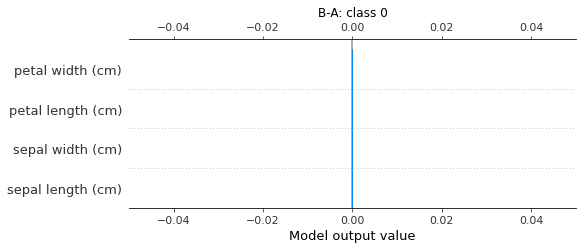

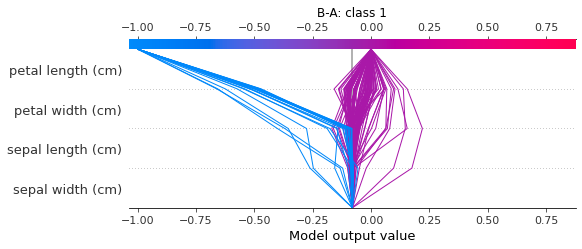

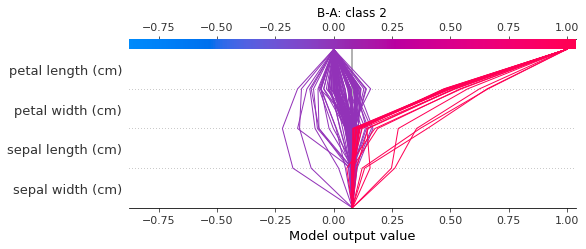

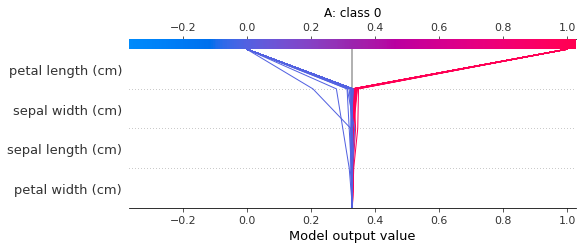

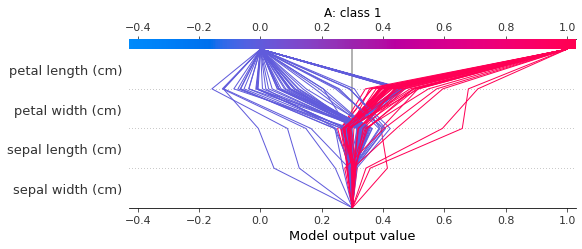

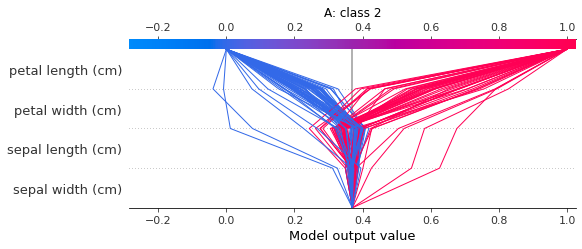

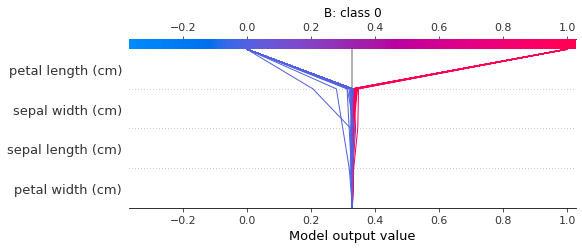

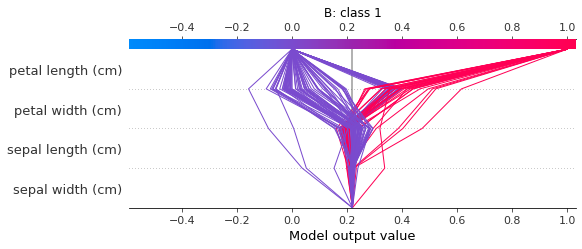

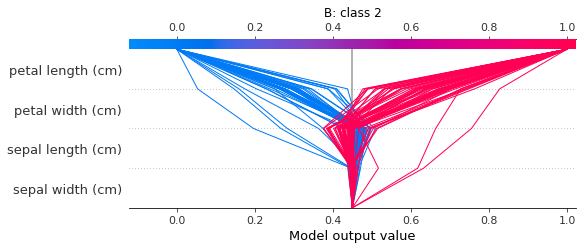

In [84]:
for name, shap_values in [('B-A', shap_values_a_vs_b), ('A', shap_values_a), ('B', shap_values_b)]:
    for class_idx, class_ in enumerate(clf_a.classes_):
        shap_values_ = shap_values[indices_sample, :, class_idx]
        shap.plots.decision(shap_values_.base_values[0], shap_values_.values, feature_names=feature_names.tolist(), title=f'{name}: class {class_}')